# Conditional DCGAN with minibatch discrimination on CIFAR-10 dataset

Here we will implement a conditional DCGAN with minibatch discrimination on the CIFAR-10 dataset.

Minibatch discrimination was described in : https://arxiv.org/abs/1606.03498 

This implementation requires **Tensorflow 2.0**. The first few cells are only related to Google Colab and Google Drive, you can ignore them.

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

If executing on Google Colab, mount your Google Drive (click the link, connect and enter the password)

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('drive/My Drive/tuto_gan/Notebooks for guide')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports, helper functions and preliminaries

Importing the libraries

In [0]:
# Coding
import tensorflow as tf 
from tensorflow.keras import layers
import numpy as np

# Plotting and manipulating images
import matplotlib.pyplot as plt
import imageio
import glob
import PIL
from IPython import display

# Timing
import datetime
import time

# Managing the folders 
import os
import shutil

Creating the folders

In [0]:
# Removing the old images generated during training

NAME_FILE = "Minibatch discrimination/200ep/Une couche après"

rm_path = "." + os.sep + NAME_FILE + os.sep + "imgs"
if os.path.exists(rm_path):
    shutil.rmtree(rm_path)

# Creating folders to save images, models and checkpoints
newpaths = ["." + os.sep + NAME_FILE + os.sep + "imgs", 
            "." + os.sep + NAME_FILE + os.sep + "models",
            "." + os.sep + NAME_FILE + os.sep + "losses"]
for newpath in newpaths:
    if not os.path.exists(newpath):
        os.makedirs(newpath)

Helper functions

In [0]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
NUM_CLASSES = len(CLASSES)

def generate_and_save_images(model,
                             epoch,
                             test_input,
                             g_loss,
                             d_loss,
                             conditions=None,
                             x_axis="scale",
                             y_max=5):

  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    if conditions is not None:
        predictions = model([test_input, conditions], training=False)
    else:
        predictions = model([test_input], training=False)

    fig = plt.figure(figsize=(20,8))
    outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

    inner_im = gridspec.GridSpecFromSubplotSpec(4, 5,
                  subplot_spec=outer[0], wspace=0.1, hspace=0.1)

    for i in range(predictions.shape[0]):
        ax = plt.Subplot(fig, inner_im[i])
        ax.imshow((predictions[i]+1) / 2 )
        if conditions is not None:
            ax.title.set_text(CLASSES[np.argmax(conditions[i])])
        ax.axis('off')
        fig.add_subplot(ax)
    fig.savefig("." + os.sep + NAME_FILE + os.sep + 'imgs' + os.sep + 'image_at_epoch_{:04d}.png'.format(epoch), bbox_inches="tight")
    
    
    inner_l = gridspec.GridSpecFromSubplotSpec(1, 1,
                  subplot_spec=outer[1], wspace=0.1, hspace=0.1)
    
    ax1 = plt.Subplot(fig, inner_l[0])
    
    samples = 1000
    g_losses_sampled = []
    d_losses_sampled = []
    xs = []

    for i in range(len(g_loss) // samples):
        g_losses_sampled.append(np.mean(g_loss[i*samples:(i+1)*samples]))
        d_losses_sampled.append(np.mean(d_loss[i*samples:(i+1)*samples]))
        xs.append(i*samples + samples/2)

    ax1.plot(xs, g_losses_sampled, "r-")
    ax1.plot(xs, d_losses_sampled, "b-")

    red_patch = mpatches.Patch(color='red', label='Generator loss')
    blue_patch = mpatches.Patch(color='blue', label='Discriminator loss')
    ax1.legend(handles=[red_patch,blue_patch])
    
    if x_axis == "total":
        ax1.set_xlim([0, train_images.shape[0]//BATCH_SIZE * EPOCHS])
    else:
        ax1.set_xlim([0, xs[-1] + xs[-1]*0.1])
    ax1.set_ylim([0, y_max])
    
    
    
    fig.add_subplot(ax1)
    
    plt.show()


# Hyperparameters

In [0]:
# Training parameters
EPOCHS =         200
BATCH_SIZE =     128      # Amount of images processed before backpropagating

# Models parameters
NOISE_DIM =      100      # Amount of features for the generator
KERNEL_SIZE =    (5, 5)   # Kernel size for the convolutional layers
MOMENTUM =       0.9      # Momentum for the batch normalization layers
DROPOUT =        0.4      # Dropout rate
ALPHA =          0.2      # Alpha for the leaky ReLU slope

# Optimizer parameters
LEARNING_RATE =  2e-4     # Learning rate for the Adam Optimizer
BETA_1 =         0.5      # Beta_1 for the Adam Optimizer
BETA_2 =         0.9      # Beta_2 for the Adam Optimizer

# Display parameters
NUM_EXAMPLES =   20       # Amount of examples to generate

# Data loading and preprocessing

Loading and preprocessing the dataset. We will use CIFAR-10.

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

# Shape of the training dataset
IMAGE_SIZE =     train_images.shape[-2] # Size of the images of the training dataset (width and height)
IMAGE_CHANNELS = train_images.shape[-1] # Amount of channels of the training dataset (depth)

# Preprocessing the dataset
train_images = train_images.reshape(train_images.shape[0], IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_labels = tf.one_hot(train_labels, NUM_CLASSES)
train_labels = tf.reshape(train_labels, (train_labels.shape[0], train_labels.shape[2]))

# Network Architecture

In this section, we will detail what architectures are used for training the conditional DCGAN.

**For our generator, we will use the following architecture :**

In [0]:
# Constructing the conditional generator

def generator_model(input_layer, condition_layer, verbose=False):
    
    # Constrain the generator with a condition
    merged_in = layers.Concatenate()([input_layer, condition_layer])

    hid = layers.Dense(256 * 4 * 4)(merged_in)
    hid = layers.Reshape((4, 4, 256))(hid)
    hid = layers.ReLU()(hid) 
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    # 4 ==> 8
    hid = layers.Conv2DTranspose(   256, kernel_size=KERNEL_SIZE, strides=(2, 2), padding="same", use_bias=False)(hid)
    hid = layers.ReLU()(hid)
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    # 8 ==> 16
    hid = layers.Conv2DTranspose(   128, kernel_size=KERNEL_SIZE, strides=(2, 2), padding="same", use_bias=False)(hid)
    hid = layers.ReLU()(hid)
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    # 16 ==> 32    
    hid = layers.Conv2DTranspose(   64, kernel_size=KERNEL_SIZE, strides=(2, 2), padding="same", use_bias=False)(hid)
    hid = layers.ReLU()(hid)
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    hid = layers.Conv2D(IMAGE_CHANNELS, kernel_size=KERNEL_SIZE, strides=(1, 1), padding="same")(hid)
    out = layers.Activation("tanh")(hid)

    model = tf.keras.Model(inputs=[input_layer, condition_layer], outputs=out)
    
    if verbose:
        model.summary()
    
    return model

**For our discriminator, we will use the following architecture :**

In [0]:
def discriminator_model(input_layer, condition_layer, verbose=False):

    # 32 ==> 16
    hid = layers.Conv2D(64,  kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same', use_bias=False)(input_layer) 
    hid = layers.LeakyReLU(alpha=ALPHA)(hid) 
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)

    # 16 ==> 8
    hid = layers.Conv2D(128, kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same', use_bias=False)(hid)
    hid = layers.LeakyReLU(alpha=ALPHA)(hid) 
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)

    # 8 ==> 4
    hid = layers.Conv2D(256, kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same', use_bias=False)(hid)
    hid = layers.LeakyReLU(alpha=ALPHA)(hid) 
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)

    hid = layers.Flatten()(hid)
    
    hid =    layers.Dense(256)(hid)
    hid =    layers.LeakyReLU(alpha=ALPHA)(hid)
    
    # Indicating the discriminator the condition
    merged = layers.Concatenate()([hid, condition_layer])

#     hid =    layers.Dense(256)(merged)
#     hid =    layers.LeakyReLU(alpha=ALPHA)(hid)
    
    hid = MinibatchDiscrimination(num_kernel=100, dim_kernel=5, name="mbd")(merged)

    hid =    layers.Dense(256)(hid)
    hid =    layers.LeakyReLU(alpha=ALPHA)(hid)
    out = layers.Dense(1)(hid) # No sigmoid activation because we use Cross Entropy with from_logits=True
    
    model = tf.keras.Model(inputs=[input_layer, condition_layer], outputs=out)
    
    if verbose:
        model.summary()
    
    return model

Creation of the minibatch discrimination custom layer : 

In [0]:
#Flattened input

class MinibatchDiscrimination(tf.keras.layers.Layer):

    def __init__(self, num_kernel, dim_kernel,kernel_initializer='glorot_uniform', **kwargs):
        self.num_kernel = num_kernel
        self.dim_kernel = dim_kernel
        self.kernel_initializer = kernel_initializer
        super(MinibatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.num_kernel*self.dim_kernel),
                                      initializer=self.kernel_initializer,
                                      trainable=True)
        super(MinibatchDiscrimination, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        activation = tf.matmul(x, self.kernel)
        activation = tf.reshape(activation, shape=(-1, self.num_kernel, self.dim_kernel))
        #Mi
        tmp1 = tf.expand_dims(activation, 3)
        #Mj
        tmp2 = tf.transpose(activation, perm=[1, 2, 0])
        tmp2 = tf.expand_dims(tmp2, 0)
        
        diff = tmp1 - tmp2
        
        l1 = tf.reduce_sum(tf.math.abs(diff), axis=2)
        features = tf.reduce_sum(tf.math.exp(-l1), axis=2)
        return tf.concat([x, features], axis=1)        
        
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + self.num_kernel)

Loading the generator

In [0]:
noise_input = layers.Input(shape=(NOISE_DIM,)) # Noise input
gen_cond_in = layers.Input(shape=(NUM_CLASSES,)) # Condition input
generator = generator_model(noise_input, gen_cond_in, verbose=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 4096)         454656      concatenate[0][0]            

Loading the discriminator

In [0]:
img_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)) # Image input
disc_cond_in = layers.Input(shape=(NUM_CLASSES,)) # Condition input
discriminator = discriminator_model(img_input, disc_cond_in, verbose=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   4800        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 16, 16, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 16, 16, 64)   256         leaky_re_lu[0][0]                
____________________________________________________________________________________________

# Optimizers and losses

In [0]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

The discriminator will try to recognize ground truth data by predicting 1, and to recognize the generated images by predicting 0. Thus, we will use the binary crossentropy of the difference between the values predicted and the expected values as a measure of the loss. 

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    # real_loss will quantify our loss to distinguish the real images
    
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    # fake_loss will quantify our loss to distinguish the fake images (generated)
    
    # Real image = 1, Fake image = 0 (array of ones and zeros)
    total_loss = real_loss + fake_loss
    return total_loss

The generator will try to fool the discriminator by making the generated images’ predictions be the closest to 1. We will then use the binary crossentropy of the difference between the discriminator’s predictions over generated data and 1 as a measure of the loss.

In [0]:
def generator_loss(fake_output):
    # We want the false images to be seen as real images (1)
    return loss_function(tf.ones_like(fake_output), fake_output)

For both the generator and the discriminator, we will use the Adam optimizer.

In [0]:
generator_optimizer =     tf.keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)

# Training

We code the train steps manually to have complete control over the process.

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be converted 
# from Eager mode of Tensorflow (easier to code but slower to execute) 
# to Graph mode (harder to code but faster to execute)

@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # To make sure we know what is done, we will use a gradient tape instead of compiling
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Training the generator
        generated_images = generator([noise, labels] , training=True) 

        # Training the discriminator
        real_output = discriminator([images, labels], training=True)           # Training the discriminator on real images
        fake_output = discriminator([generated_images, labels], training=True) # Training the discriminator on fake images

        # Calculating the losses
        gen_loss =  generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Building the gradients
        gradients_of_generator =     gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # Applying the gradients (backpropagation)
        generator_optimizer.apply_gradients(    zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        return gen_loss, disc_loss


In [0]:
g_losses = []
d_losses = []
def train(train_images, train_labels, epochs, seed, seed_labels):

    num_batches = int(train_images.shape[0]/BATCH_SIZE) # Amount of batches
    for epoch in range(epochs):
        start = time.time() # Timing the epoch

        for batch_idx in range(num_batches): # For each batch
            images = train_images[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
            labels = train_labels[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
            gen_loss, disc_loss = train_step(images, labels)
            
            # Saving the losses
            g_losses.append(np.array(gen_loss))  
            d_losses.append(np.array(disc_loss))

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed,
                                 g_losses,
                                 d_losses,
                                 conditions=seed_labels,
                                 x_axis='total')

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print("Generator loss for last batch: ",g_losses[-1])
        print("Discriminator loss for last batch: ",d_losses[-1])

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed,
                               g_losses,
                               d_losses,
                               conditions=seed_labels,
                               x_axis='total')

We will reuse this seed overtime, so it's easier to visualize progress in the animated GIF.

In [0]:
seed = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])
seed_labels = tf.one_hot([0,1,2,3,4,0,1,2,3,4,5,6,7,8,9,5,6,7,8,9], NUM_CLASSES)

This following cell launches the training.

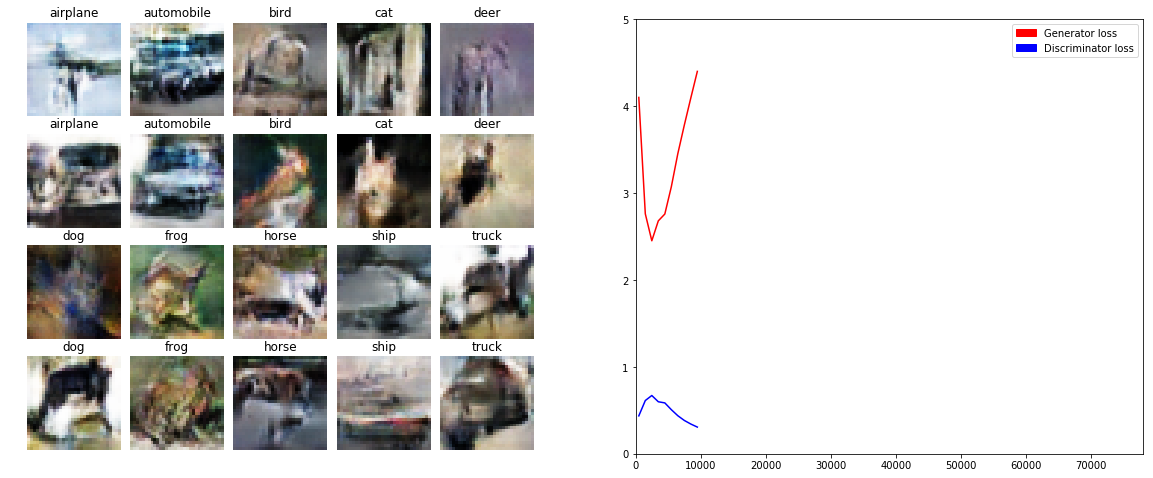

Time for epoch 27 is 33.82824420928955 sec
Generator loss for last batch:  4.7958755
Discriminator loss for last batch:  0.21754818


In [0]:
%%time
# Training
train(train_images, train_labels, EPOCHS, seed, seed_labels)

# Immedialty save the models
generator.save(    "." + os.sep + NAME_FILE + os.sep + 'models' + os.sep + 'generator.h5')
discriminator.save("." + os.sep + NAME_FILE + os.sep + 'models' + os.sep + 'discriminator.h5')

# Saving and loading the models

Saving the models and the losses

In [0]:
generator.save(    "." + os.sep + NAME_FILE + os.sep + 'models' + os.sep + 'generator.h5')
discriminator.save("." + os.sep + NAME_FILE + os.sep + 'models' + os.sep + 'discriminator.h5')

np.save("." + os.sep + NAME_FILE + os.sep + 'losses' + os.sep + 'g_losses_cond.npy',g_losses)
np.save("." + os.sep + NAME_FILE + os.sep + 'losses' + os.sep + 'd_losses_cond.npy',d_losses)

Loading the models

In [0]:
generator_l =     tf.keras.models.load_model("." + os.sep + NAME_FILE + os.sep + "models" + os.sep + "generator.h5")
discriminator_l = tf.keras.models.load_model("." + os.sep + NAME_FILE + os.sep + "models" + os.sep + "discriminator.h5")

# Visualizing the losses

In [0]:
samples = 256
g_losses_sampled = []
d_losses_sampled = []
xs = []


for i in range(len(g_losses) // samples):
    g_losses_sampled.append(np.mean(g_losses[i*samples:(i+1)*samples]))
    d_losses_sampled.append(np.mean(d_losses[i*samples:(i+1)*samples]))
    xs.append(i*samples + samples/2)

plt.figure(figsize=(20,10))
  
plt.plot(xs, g_losses_sampled, "r-")
plt.plot(xs, d_losses_sampled, "b-")

red_patch = mpatches.Patch(color='red', label='Generator loss')
blue_patch = mpatches.Patch(color='blue', label='Discriminator loss')
plt.legend(handles=[red_patch,blue_patch])
plt.show()


# Generating a GIF of the training process

In [0]:
anim_file = "." + os.sep + NAME_FILE + os.sep + 'CIFAR-10.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob("." + os.sep + NAME_FILE + os.sep + 'imgs' + os.sep + 'image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 10*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# Generating samples from a specific class

In [0]:
def show_class(model, k=None, classes=None):
    if classes:
        print("Generating {} images...".format(classes[k]))
        input = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])
        labels = tf.one_hot([k]*NUM_EXAMPLES,10)
        predictions = model([input, labels], training=False)
    else:
        print("Generating images...")
        input = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])
        labels=None
        predictions = model([input], training=False)
        

    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 5, i+1)
        if classes:
            plt.title(classes[k])
        plt.imshow((predictions[i]+1) / 2)
        plt.axis('off')
    plt.show()
    
show_class(generator_l, k=0, classes=CLASSES)